<a href="https://colab.research.google.com/github/eordog/erdos_artemis/blob/main/brain_tumor_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Create labels

In [ ]:
labels = ['glioma_coronal','meningioma_coronal','pituitary_coronal','no_coronal','glioma_sagittal','meningioma_sagittal','pituitary_sagittal','no_sagittal','glioma_transverse','meningioma_transverse','pituitary_transverse','no_transverse']

Import dataset

In [ ]:
X_train = []
y_train = []

image_size = 160 # One of the custom image size for MobileNetV2
for i in labels:
    folderPath = os.path.join('/content/gdrive/MyDrive/Brain_Tumor_Data_Final','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/gdrive/MyDrive/Brain_Tumor_Data_Final','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 96/96 [00:58<00:00,  1.65it/s]


Randomly shuffel the dataset for train-validation-test split

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=202)

Plot sample MRI image from each category

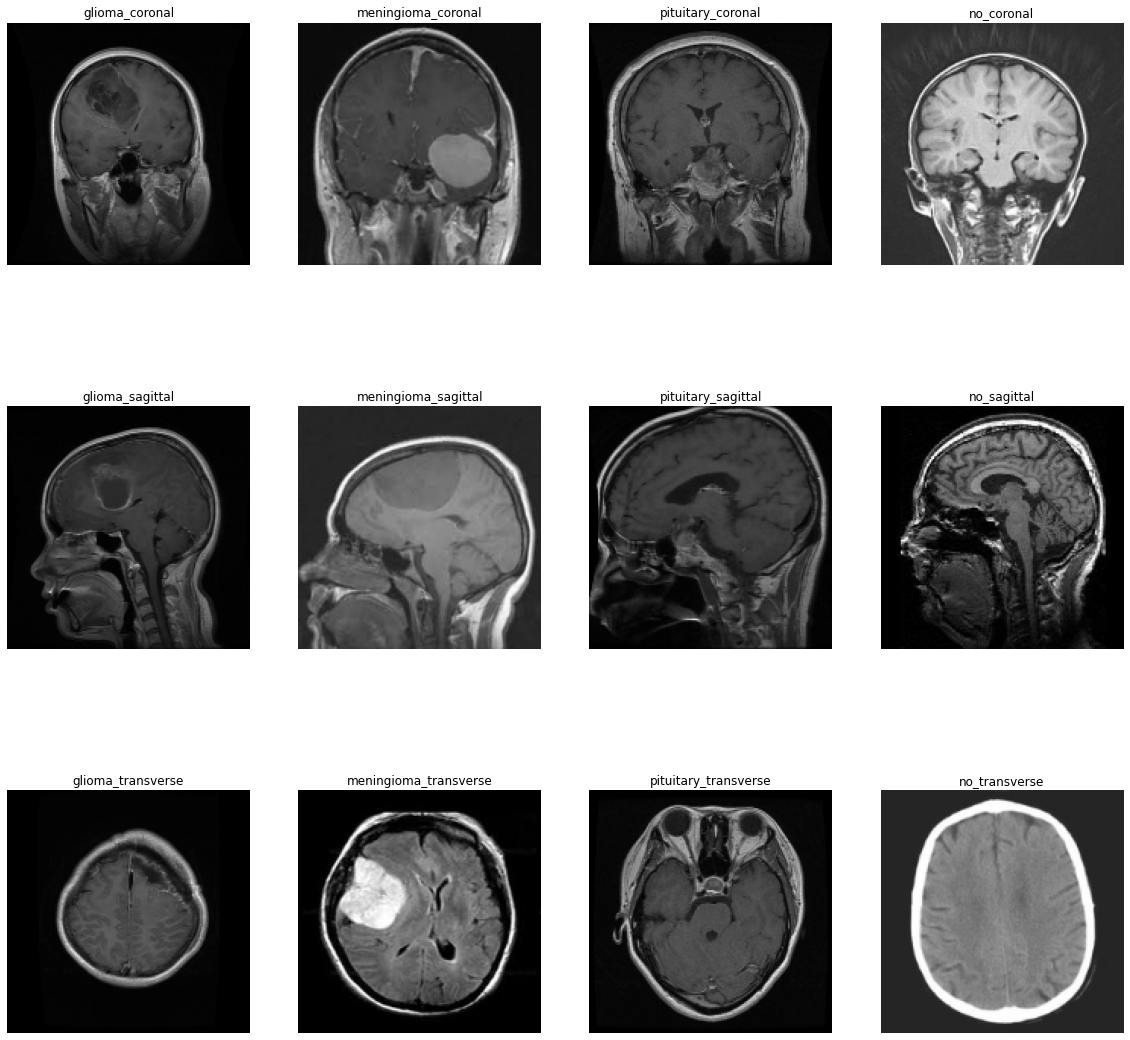

In [ ]:
k=0
l=0
fig, ax = plt.subplots(3,4,figsize=(20,20))
for i in labels:
    j=0
    while True:
        if y_train[j]==i:
            ax[k,l].imshow(X_train[j])
            ax[k,l].set_title(y_train[j])
            ax[k,l].axis('off')
            l+=1
            if l==4:
              l=0
              k+=1
            break
        j+=1

Split into training (90%) and testing (10%) sets

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=201)

Perform One Hot Encoding on labels

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

Use the MobileNetV2 model with weights from the ImageNet dataset. Exclude the output layer from the MobileNetV2 model to add our own output layers

In [ ]:
mobnet = MobileNetV2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3),alpha=1.0)

9420800/9406464 [==============================] - 1s 0us/step


Add an average pooling layer and a dropout layer to avoid overfitting. Complete the model with a 12-unit output layer with softmax activation function

In [ ]:
model = mobnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(12,activation='softmax')(model)
model = tf.keras.models.Model(inputs=mobnet.input, outputs = model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']           

Compile the model

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

Save the model with the highest validation accuracy and adjust the learning rate based on validation accuracy of each epoch

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint_filepath = '/content/gdrive/MyDrive/Save_Model'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

Further split the data into training (90%) and validation (10%) sets. Train the data for 30 epochs with a batch size of 32 images

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =30, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.7989 - accuracy: 0.7363
Epoch 1: val_accuracy improved from -inf to 0.09898, saving model to /content/gdrive/MyDrive/Save_Model
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Save_Model/assets
83/83 [==============================] - 42s 329ms/step - loss: 0.7989 - accuracy: 0.7363 - val_loss: 8.7502 - val_accuracy: 0.0990 - lr: 0.0010
Epoch 2/30
82/83 [============================>.] - ETA: 0s - loss: 0.3791 - accuracy: 0.8739
Epoch 2: val_accuracy improved from 0.09898 to 0.36177, saving model to /content/gdrive/MyDrive/Save_Model
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Save_Model/assets
83/83 [==============================] - 24s 291ms/step - loss: 0.3786 - accuracy: 0.8740 - val_loss: 9.3714 - val_accuracy: 0.3618 - lr: 0.0010
Epoch 3/30
82/83 [============================>.] - ETA: 0s - loss: 0.2746 - accuracy: 0.9158
Epoch 3: val_accuracy did not improve from 0.36177
83/83 [=====

Use the trained model to predict the testing dataset

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        38
           1       0.81      1.00      0.90        30
           2       0.96      0.96      0.96        26
           3       0.00      0.00      0.00         1
           4       0.97      1.00      0.98        28
           5       1.00      0.96      0.98        27
           6       1.00      1.00      1.00        26
           7       1.00      0.86      0.92         7
           8       1.00      0.91      0.96        35
           9       0.92      0.97      0.94        35
          10       0.97      1.00      0.98        30
          11       1.00      0.95      0.98        42

    accuracy                           0.95       325
   macro avg       0.89      0.87      0.88       325
weighted avg       0.96      0.95      0.96       325



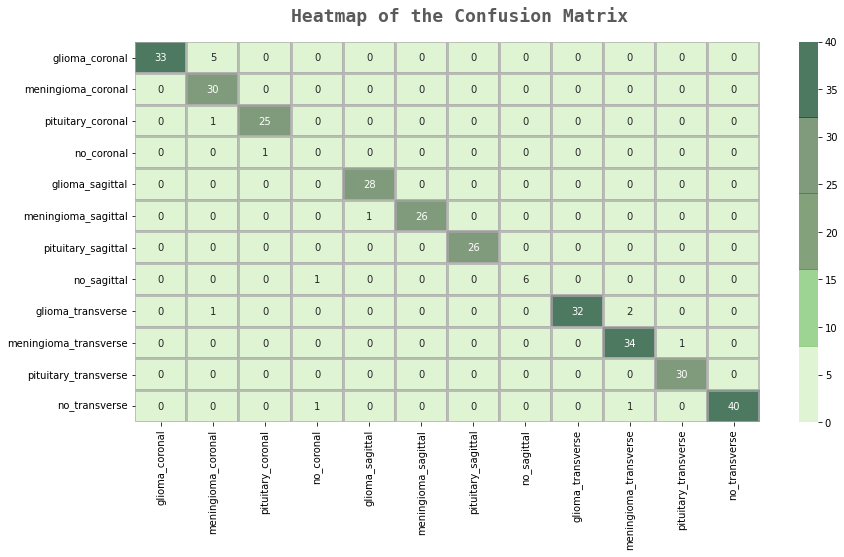

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()